# 01_summary_statistics.ipynb

In [1]:
import sys
sys.path.append('..')
import contextily as cx
import figure_utilities
import figure_and_table_constants
from analysis_utilities import produce_summary_statistics
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd
from scipy import stats
import xyzservices.providers as xyz

# Store paths.
INPUT_DATA_UNRESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/unrestricted.csv"
INPUT_DATA_RESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/zestimates_analysis.csv"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/tables"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_csv(INPUT_DATA_UNRESTRICTED)

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

# So we can use 'case_number' like a column
unrestricted_df = unrestricted_df.reset_index()

/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_64680/1148381516.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from 

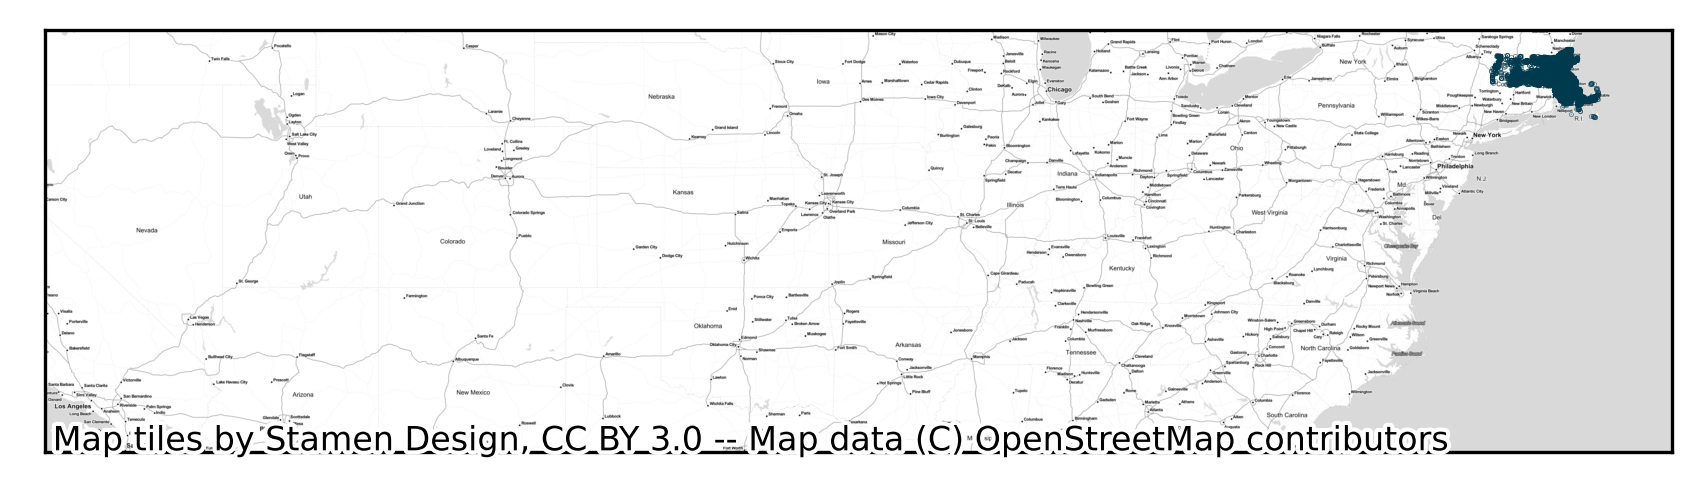

In [2]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color=figure_and_table_constants.Colors.P3,
                      markersize=0.05,
                      alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

In [3]:
# Plot the number of eviction filings over time.
unrestricted_df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(unrestricted_df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = unrestricted_df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_title("Prevalence of Eviction Filings Over Time in Massachusetts")
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
                   Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
                         alpha=0.5, linestyle='--'),
                   Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
                         linestyle='--'),
                   Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
                         linestyle='--')]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

KeyError: 'Column not found: case_number'

In [ ]:
# Produce summary statistics for unrestricted sample.
treatment_date_variable = 'file_date'
summary_statistics_unrestricted, variable_display_names_dict  = produce_summary_statistics(unrestricted_df,
                                                                                           treatment_date_variable=treatment_date_variable)

# Rename rows.
variable_names = summary_statistics_unrestricted.index.get_level_values(1)
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(index=variable_display_names_dict)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(columns=column_display_names_dict)
summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

In [ ]:
# Load restricted data.
restricted_df = pd.read_csv(INPUT_DATA_RESTRICTED)
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
restricted_df = restricted_df.dropna(subset=['file_date'])
print(f"Limiting sample to {len(restricted_df)} evictions for which we observe the filing date and the latest docket date.")

# Create dictionaries to map between string representation and integer representation of each month.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

In [ ]:
treatment_timings = (restricted_df
                     .groupby([treatment_month_variable, 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index=treatment_month_variable, columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(restricted_df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Filing Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Filing Month")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                          'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings

In [ ]:
# Reshape from wide to long.
restricted_df = pd.melt(restricted_df,
                        id_vars=['case_number', treatment_month_variable, 'judgment_for_plaintiff'],
                        value_vars=value_vars, var_name='month', value_name='zestimate')
restricted_df = restricted_df.sort_values(by=['case_number', 'month'])

In [ ]:
# Plot path of the outcome in the treated vs. control group.

# Convert months from string format to integer format.
restricted_df.loc[:, 'month'] = restricted_df['month'].replace(month_to_int_dictionary)
restricted_df.loc[:, treatment_month_variable] = restricted_df[treatment_month_variable].replace(month_to_int_dictionary)

# Generate month relative to treatment.
restricted_df.loc[:, 'month_relative_to_treatment'] = ((restricted_df['month'] - restricted_df[treatment_month_variable])
                                                       .astype(int))



# Aggregate by treatment-relative month and treatment status.
start_month_relative_to_treatment = -12
end_month_relative_to_treatment = 24
restricted_df = (restricted_df.groupby(['month_relative_to_treatment', 'judgment_for_plaintiff'])['zestimate']
                 .agg([np.mean, np.std, 'count'])
                 )
restricted_df.loc[:, 'se'] = restricted_df['std'] / np.sqrt(restricted_df['count'])
restricted_df.loc[:, 'y_upper'] = restricted_df['mean'] + 1.96 * restricted_df['se']
restricted_df.loc[:, 'y_lower'] = restricted_df['mean'] - 1.96 * restricted_df['se']

# Separate into control and treatment group
treated_units = restricted_df.loc[(slice(start_month_relative_to_treatment, end_month_relative_to_treatment), 1), :].reset_index()
control_units = restricted_df.loc[(slice(start_month_relative_to_treatment, end_month_relative_to_treatment), 0), :].reset_index()

# Plot event study-style plot of trends in Zestimates.
fig, ax = plt.subplots()
if treatment_date_variable == 'file_date':
    ax.set_xlabel("Month Relative to File Date")
elif treatment_date_variable == 'latest_docket_date':
    ax.set_xlabel("Month Relative to Latest Docket Date")
else:
    raise ValueError("Invalid treatment_date_variable.")
ax.set_ylabel("Zestimate")
for dataset, color, marker, label in zip([treated_units, control_units],
                                         ['red', 'blue'],
                                         ["^", "s"],
                                         ["Cases Won By Plaintiff",
                                          "Cases Won By Defendant"]):
    x = dataset['month_relative_to_treatment'].values
    y = dataset['mean'].values
    y_upper = dataset['y_upper'].values
    y_lower = dataset['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax=ax,
                                                     x=x,
                                                     y=y,
                                                     y_upper=y_upper,
                                                     y_lower=y_lower,
                                                     label=label,
                                                     point_color=color,
                                                     marker=marker,
                                                     error_color=color,
                                                     error_opacity=0.3)

ax.legend()
ax.grid(True)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates.png"))


